# <center> TP5 - Pagerank </center>
<center> 2023/2024 - T. Godin, L. Naert </center>
<center> IUT de Vannes, BUT Informatique </center>




***
**Sources :**
- [Thibault Godin](https://thibgodin.github.io/) (IUT de Vannes)
- [Kyle Kastner](http://kastnerkyle.github.io/) (Université de Montréal)
- [Generalized Optimization Framework for Graph-based Semi-supervised Learning](https://hal.inria.fr/inria-00633818/document)

***
Ce TP s'intéresse au _ranking_ au sein d'un graphe orienté. Il s'agit d'un domaine qui s'intéresse aux façon de mesurer l'importance / la pertinence des noeuds d'un graphe. Nous avons déjà vu la notion intimement liée de _centralité_ (degré, degré pondéré, betweenness, closeness) en cours de graphe.

Dans le contexte de la recherche sur le Web, la pertinence dépend généralement du contenu d'une page Web : si une page Web contient les termes de recherche, nous supposons qu'elle est pertinente par rapport aux termes de recherche.

La qualité d'une page Web dépend aussi des liens entre les pages : s'il existe de nombreux liens vers une page particulière, il est vraisemblable qu'elle soit de haute qualité, surtout si ces liens proviennent de pages qui sont elles-mêmes de haute qualité.

L'un des premiers algorithmes à quantifier la qualité est le **PageRank**, qui était au cœur du moteur de recherche original de Google.
Comparé aux [moteurs de recherche antérieurs](https://www.makeuseof.com/tag/7-search-engines-that-rocked-before-google-even-existed/), cet algorithme a permis un bond significatif dans la qualité des résultats obtenus.

PageRank est décrit dans ["The PageRank citation ranking: Bringing order to the Web"](https://web.archive.org/web/20110818093436/http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) par Page, Brin, Motwani et Winograd.

C'est un algorithme étonnamment simple. Il peut être calculé et mis à jour efficacement, et il est très efficace pour identifier les pages de bonne qualité.

In [1]:
import networkx as nx
import numpy as np
from numpy import linalg as la
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import pandas as pd
plt.figure(figsize = (10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Comme exemple, on pourra utiliser un graphe `G` généré avec `random_k_out_graph` :

* Chaque nœud a le même nombre de liens sortants `k`,

* Le nombre de liens entrants varie modérément (contrôlé par le paramètre 'alpha').

* Les auto-boucles et les liens multiples sont autorisés.

In [2]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)

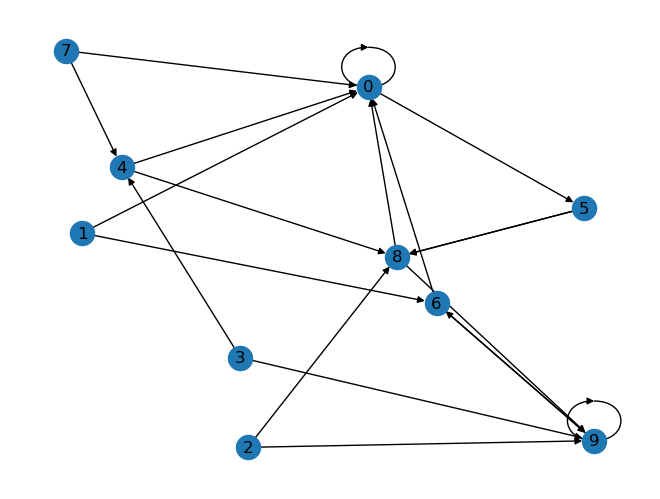

In [3]:
nx.draw(G,with_labels=True)

> __Question 1 (Compréhension)__ : Si un sommet représente un site. Que représente les arcs ? Et les auto-boucles ? Et les arcs multiples ? 

Réponse : 



`NetworkX` fournit une implémentation `nx.pagerank` de PageRank que nous pouvons utiliser pour calculer une métrique "d'importance" pour chaque page (noeud). Essayer sur différents graphes `G`. Vous devriez constater que les nœuds avec plus de liens entrants obtiennent des scores plus élevés.

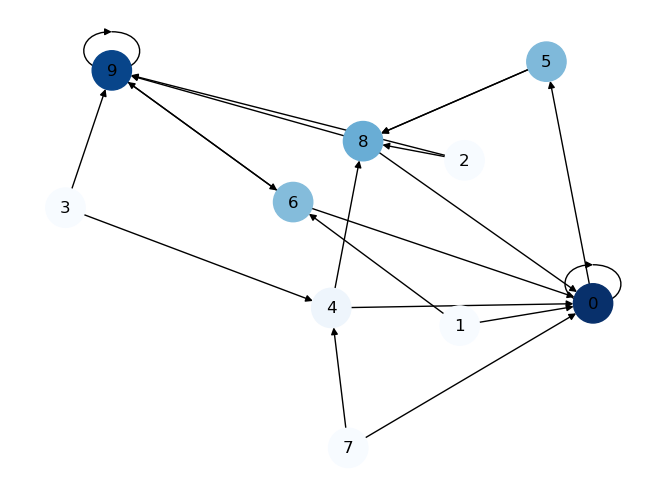

In [4]:
rangs_pr = nx.pagerank(G)
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

> __Question 2 (Compréhension)__ :Visualiser l'importance donnée aux noeuds des trois graphes suivant par PageRank. Interpréter les résultats.

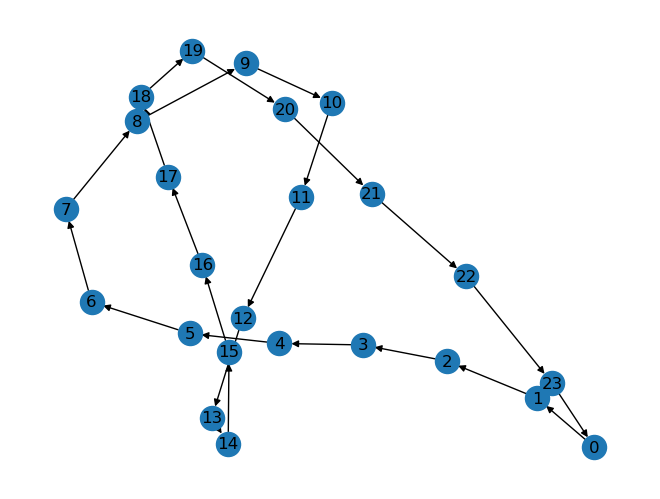

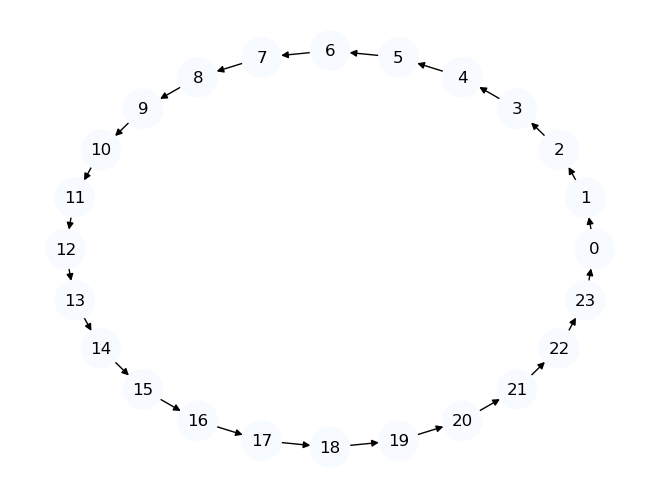

In [5]:
#Graphe cyclique
G = nx.cycle_graph(24, create_using = nx.DiGraph)
nx.draw(G,with_labels=True)
plt.show() 
rangs_pr = nx.pagerank(G)
pos = nx.circular_layout(G)
nx.draw(G, pos , node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

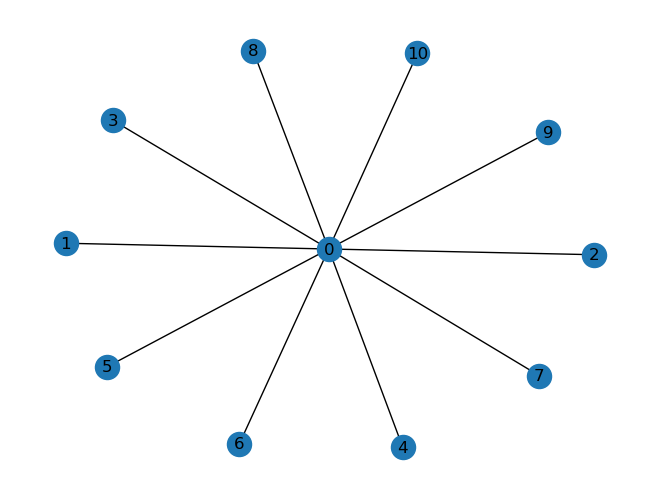

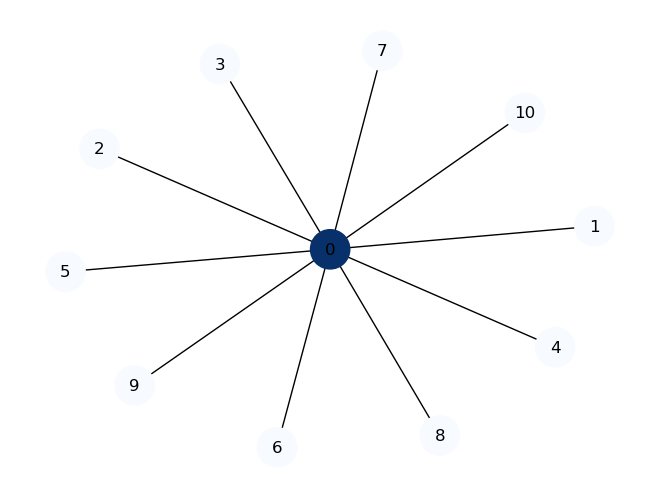

In [6]:
# Graphe étoilé
G=nx.generators.classic.star_graph(10)
nx.draw(G,with_labels=True)
plt.show()
rangs_pr = nx.pagerank(G)
pos = nx.spring_layout(G)
nx.draw(G, pos , node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

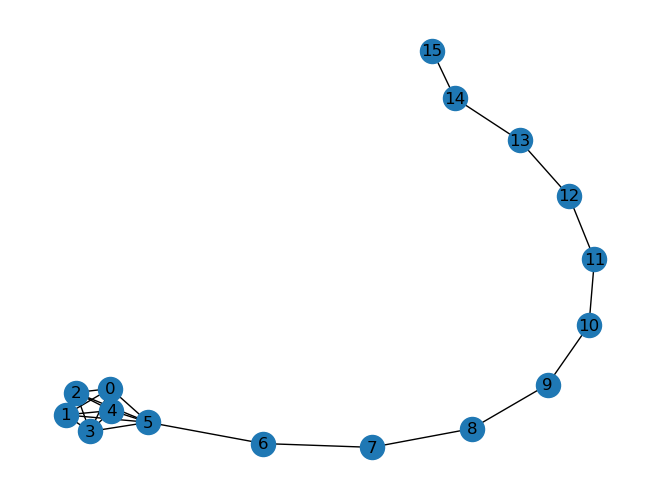

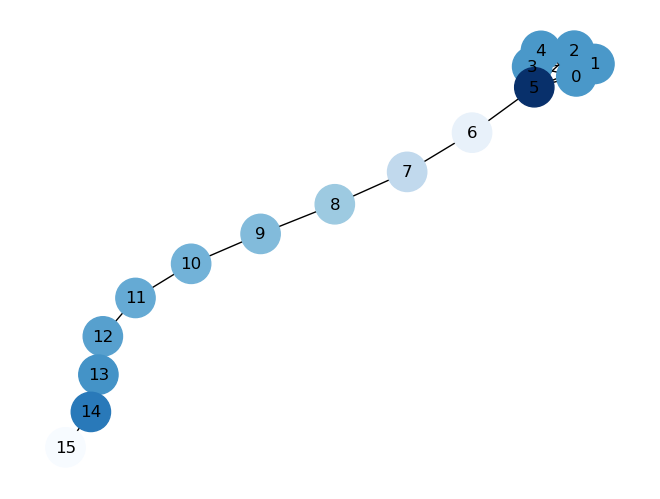

In [7]:
# Graphe de la sucette
G=nx.generators.classic.lollipop_graph(6,10)
nx.draw(G,with_labels=True)
plt.show()
rangs_pr = nx.pagerank(G)
pos = nx.spring_layout(G)
nx.draw(G, pos , node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

Voyons maintenant comment PageRank fonctionne.

# Marche aléatoire et théorème ergodique

On peut construire l'algorithme PageRank à partir d'une marche aléatoire directement sur le graphe :
- On choisit un nœud `node` au hasard dans `G`;
- À chaque itération, on se déplace depuis le noeud `node` courant vers un de ses voisins (dans `G[node]`) via l'un de ses liens sortants tiré uniformément.

On note à chaque fois le nœud visité.

Si un nœud a beaucoup de liens entrants, vous êtes susceptible de le visiter plus souvent.
Et si ces liens entrants proviennent de nœuds avec de nombreux liens entrants, encore plus.

Cependant, il y a un hic : si un nœud ne contient pas de liens sortants, ou si un ensemble de nœuds forme une boucle sans liens sortants, le marcheur aléatoire se retrouve piégé indéfiniment.

Pour éviter cela, la version native de PageRank modifie légèrement cette marche aléatoire afin qu'à chaque étape, il y ait une certaine probabilité que le marcheur saute vers un nœud aléatoire plutôt que de suivre un lien. On appelle cela une _téléportation_.
Cette probabilité est déterminée par un paramètre, `alpha`, qui est la probabilité de suivre un lien, donc `1-alpha` est la probabilité de faire un saut aléatoire.

Vous allez implémenter cette marche aléatoire sur un multigraphe (plusieurs arcs identiques ou "liens multiples") orienté non-pondéré `G`, et qui incrémente un compteur pour suivre le nombre de fois qu'elle visite chaque nœud. Ici, le fait que `G` est un multigraphe modélise les multiples liens entre les pages Web. Cela permet de ne pas avoir à gérer de poids sur les arrêtes.

> __Question 3 (tirage aléatoire)__ : Ecrire une fonction `flip(alpha)` qui tire un nombre au hasard entre 0 et 1 et renvoie `True` si ce nombre est inférieur strictement à `alpha`, `False` sinon. Cette fonction sera utile pour déterminer si une téléportation doit être effectuée ou non. 

In [8]:
def flip(alpha):
    return "todo"

> __Question  4 (marche aléatoire)__ : Ecrire une fonction `marche_aleatoire(G, alpha, iters)` qui renvoie 1) un dictionnaire des fréquences de visite de chaque sommet par la marche aléatoire sur `G` avec un probabilité de téléportation de `1-alpha`, et simulée pendant `iters` itérations. Ces fréquences sont  normalisées pour sommer à $1$. Le dictionnaire a pour valeurs les fréquences et pour clef les numéros des sommets, 2) la liste des sommets visités.

Pour choisir un voisin de `node` aléatoirement, on pourra utiliser la fonction `np.random.choice(list(G[node]))`. De même, on considérera l'utilisation de `np.random.choice(list(G))` pour simplifier la téléportation.

In [8]:
def marche_aleatoire(G, alpha=0.85, iters=1000):
    return "todo"

Dans `nx.pagerank`, la valeur par défaut de `alpha` est $\alpha = 0,85$. Si tout se passe comme prévu, ces valeurs devraient se rapprocher des résultats du PageRank.

> __Question  5 (Comparaison)__ : Appliquer `nx.pagerank` et `marche_aleatoire` sur le même graphe généré aléatoirement pour comparer les scores obtenus avec la marche aléatoire avec ceux obtenus avec `nx.pagerank`. Vous pouvez utiliser un dataframe pandas pour visualiser les résultats dans un tableau. Utiliser également la fonction `nx.draw` pour représenter graphiquement le graphe avec la notion d'importance. 

On appelle __fréquence d'occupation__ d'un noeud $i$ à l'itération $k$ le nombre de fois où le noeud $i$ a été visité entre la première et la $k$-ième itération

> __Question  6 (fréquence d'occupation)__ : Ecrire une fonction `trajectoire_to_frequence(noeudVisites)` qui étant donné une la liste des noeuds visités par la marche aléatoire, calcule la fréquence d'occupation de chaque noeud en fonction du nombre d'itération. Cette fonction retourne un dictionnaire avec pour clef l'indice du noeud et pour valeur la liste des fréquence __par itération__.

On pourra utiliser la fonction `np.cumsum` pour calculer des sommes cumulatives d'occupation sur une trajectoire de la marche.

 

In [9]:
def trajectoire_to_frequence(noeudVisites):
    return "todo"

Le code suivant permet d'illustrer la convergence de cet algorithme. En théorie des probabilités, cette convergence est une conséquence du **théorème ergodique**.

In [10]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)

alpha = 0.85
rangs_pr = nx.pagerank(G,alpha)

iters = 1000
x = np.array(range(1,iters+1))
_,traj = marche_aleatoire(G, alpha, iters)
freq = trajectoire_to_frequence(traj)
vals = np.unique(traj)
N = len(vals)
colors = plt.cm.rainbow(np.linspace(0, 1, N))
for i in range(N):
    plt.plot(x,rangs_pr[vals[i]]*np.ones(iters), lw = 1, linestyle='dashed', color = 'grey')
    plt.plot(x,freq[i][1:], label=vals[i], lw=2, color=colors[i])
    
plt.legend(loc  ='upper right', ncol=N/2)
plt.show()
rangs_pr = nx.pagerank(G)
nx.draw(G,pos=nx.spring_layout(G), node_color=list(rangs_pr.values()), node_size=800, cmap=plt.cm.Blues, with_labels=True)

NameError: name 'nx' is not defined

> __Question  7 (influence de $\alpha$)__ : Que devient la marche aléatoire si $\alpha = 1$ ? Et $\alpha = 0$ ?
>
> Observer, grâce aux illustrations suivantes, l'influence de $\alpha$ sur :
> - la limite ;
> - la vitesse de convergence vers cette limite.

Réponse : 

In [11]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
nx.draw(G,pos=nx.spring_layout(G), with_labels=True)
plt.show()
alphas = [0,0.5,0.7,0.8,0.9,0.99,1]
iters = 1000
x = np.array(range(1,iters+1))
i = 1
for alpha in alphas:
    i +=1
    rangs_pr = nx.pagerank(G,alpha)
    _,traj = marche_aleatoire(G, alpha, iters)
    freq = trajectoire_to_frequence(traj)
    vals = np.unique(traj)
    N = len(vals)
    colors = plt.cm.rainbow(np.linspace(0, 1, N))
    for i in range(N):
        plt.plot(x,freq[i][1:], label=vals[i], lw=2, color=colors[i])
        plt.plot(x,rangs_pr[vals[i]]*np.ones(iters), lw = 1, linestyle='dashed', color = 'grey')
    plt.legend(loc  ='upper right', ncol=N/2)
    plt.title("alpha = "+ str(alpha))
    plt.show()


NameError: name 'nx' is not defined

## Matrice d'adjacence et vecteurs propres

L'implémentation de la marche aléatoire de PageRank est conceptuellement simple, mais pas très efficace à calculer.
Une alternative consiste à utiliser la matrice d'adjacence du graphe et de calculer ses vecteurs propres.

Dans cette matrice, l'élément de la ligne `i`, colonne `j` indique le nombre d'arêtes du nœud 'i' au nœud 'j'.
Si l'on normalise cette matrice pour que la somme de chaque ligne fasse 1, chaque élément du résultat représente la probabilité d'une transition d'un nœud à l'autre. On appelle cette matrice, la **matrice de transition**.


> __Question  8 (matrice de transition)__ : Utiliser la fonction `nx.to_numpy_array` pour obtenir la matrice d'adjacence `M` du graphe `G` et normaliser la matrice précédente pour obtenir la matrice de transition.


In [12]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)


NameError: name 'nx' is not defined

On peut utiliser cette matrice renormalisée pour simuler une marche aléatoire sur `G` avec plusieurs "marcheurs" en même temps. Par exemple, en commençant avec $100$ marcheurs à chaque nœud, représentés par le tableau x :

In [13]:
N = len(G)
x = np.full(N, 100)
print(x)

NameError: name 'G' is not defined

Dans la matrice de transition $M$, $M_{i,j}$ correspond à la fraction de marcheurs au nœud i qui se déplacent vers le nœud j.

En multipliant $M$ à gauche par $x^\top$, le résultat est un vecteur contenant le nombre de marcheurs à chaque nœud après un pas de temps.

In [14]:
#Cellule à executer plusieurs fois pour observer la convergence
x = x @ M
print(x)

NameError: name 'x' is not defined

En exécutant cette cellule plusieurs fois, constater que `x` converge vers un état stable où le nombre de marcheurs à chaque nœud ne change pas beaucoup d'un pas de temps à l'autre. __En fait, on est en train d'exécuter la méthode des puissances itérées (rappel du TP précédent !) et on tend donc vers le vecteur propre associé à la plus grande valeur propre de M__

Cependant, vous remarquerez peut-être que certains nœuds perdent tous leurs marcheurs.

Pour palier ce problème, on peut ajouter des téléportations aléatoires, en utilisant la matrice de transition $P$ associée au graphe complet. Celle-ci inclut donc les transitions de tous les nœuds vers tous les autres nœuds avec une probabilité égale.

In [15]:
p = np.full((N, N), 1/N)
print(p)

NameError: name 'np' is not defined

La **Google matrix**, `GM`, est la matrice de transition correspondant à la marche aléatoire suivant, à chaque étape, une arrête de `G` avec probabilité `alpha`, et une arrête du graphe complet avec probabilité `1-alpha`.

> __Question  9 (Google matrix)__ : Reprendre les étapes précédentes pour écrire une fonction `google_matrix(G, alpha=0.85)` qui prend un graphe `G` et un `alpha` en entrée et renvoie la matrice `GM`

In [16]:
def google_matrix(G, alpha=0.85):
    return "todo"


alpha = 0.85
GM = google_matrix(G,alpha)
print(GM)

NameError: name 'G' is not defined

> __Question 10 (PageRank)__ : Ecrire une fonction `pageRankEigen(G,alpha,eps)` qui renvoie le vecteur propre associé à la plus grande valeur propre de la "Google Matrix". Attention, ce vecteur doit être __normalisé pour que ses coefficients somment à un__. Le programme s'arrête et renvoie le dernier vecteur trouvé quand la distance entre les vecteurs issus de deux itérations successives est inférieure à `eps`.

Ce vecteur, correspondant à la sortie de **PageRank**, est aussi appelé **vecteur de Perron Frobenius** (à gauche) de la "Google Matrix".

In [17]:


def pageRankEigen(G,alpha=.85,eps=1e-5):

    return "todo"


> __Question 11 (Comparaison)__ : Comparer le résultat obtenu avec la sortie de `nx.pagerank` dans un dataframe panda.

,PageRank,VecteurPropre,Diff
0,0.156047,0.156049,1.673828e-06
1,0.021375,0.021375,0.000000e+00
2,0.147928,0.147927,-1.675163e-06
3,0.291399,0.291398,-7.658080e-07
4,0.168947,0.168950,2.442306e-06
5,0.015000,0.015000,0.000000e+00
6,0.021375,0.021375,0.000000e+00
7,0.015000,0.015000,0.000000e+00
8,0.147928,0.147927,-1.675163e-06
9,0.015000,0.015000,0.000000e+00


# Applications #



## Personnages importants dans "Les Misérables" ##

La cellule suivante donne le graphe des co-occurences des personnages des Misérables. 

In [56]:
miserables=nx.generators.les_miserables_graph()

> __Question 12 (Misérables)__ : Utiliser votre fonction pageRankEigen pour calculer l'importance des personnages des Misérables.

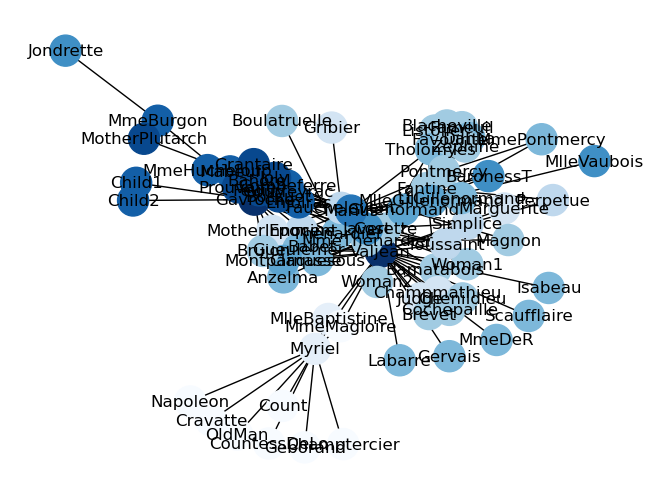